In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import calendar
import datetime as dt
from itertools import chain
from datetime import datetime, timedelta
from IPython.core import display as ICD
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from scipy import stats

In [2]:
# -- STORE ALL FITBIT DATA INTO LISTS OF SHEET --
xls_files = glob.glob('Fitbit/*.xls')

## Functions

In [3]:
def add_weekday(df, not_index=0):
    """Add day of week column"""
    
    # -- USE DATAFRAME'S INDEX IF 'not_index' = 1, OTHERWISE USE DATAFRAME'S 'Date' COLUMN --
    col = df.index
    if not_index:
        col = df['Date']
    
    # -- DETERMINE THE DAY OF WEEK FROM THE DATE AND STORE IN A LIST (USED TO ADD AS A COLUMN TO THE DATAFRAME) --
    weekday = []
    for date in col:
        #weekday.append(datetime.strptime(str(date), '%Y-%m-%d').strftime('%A'))
        weekday.append(calendar.day_name[date.weekday()])
    df.loc[:, 'Weekday'] = weekday
    
    
def to_num(df, list_of_cols):
    """Remove commas and convert values to a numeric data type"""
    
    for col in list_of_cols:
        #df[col] = df[col].str.replace(',', '')
        df[col] = df[col].str.replace('\D', '', regex=True)
        df[col] = pd.to_numeric(df[col])
        

def to_date(df, list_of_col):
    """Convert columns into datetime type"""
    
    for col in list_of_col:
        df[col] = pd.to_datetime(df[col])
        
        
def replace_outliers(df):
    """Replace outliers with mean"""
    
    for col in df.columns:
        mean = df[col].mean()
        std = df[col].std()
        df[col] = df[col].mask(((df[col] - mean).abs() > 2 * std), mean)

### Function for wrangling sleep data

In [4]:
def sort_sleep_data(list_of_df):
    """Sort sleep data by date"""
    
    for i in range(len(list_of_df)):
        list_of_df[i].sort_values(by='Start Time', ascending=True, inplace=True)

### Functions for wrangling food and macros data

In [5]:
def flatten_list(l):
    """Flatten a list"""
    
    return list(chain(*l))


def get_sheetnames_and_dates(excel_file):
    """Only get sheet names and dates for days where food data is entered"""
    """Returns: 2 lists (sheet names & dates)"""
    
    monthly_calories = pd.ExcelFile(excel_file).parse('Foods')

    dates = []
    sheet_names = []
    
    # -- GET SHEET NAMES AND DATES ONLY FOR THE DAYS WHERE INFO ABOUT FOOD INTAKE IS ENTERED --
        # -- daily[0]: date --
        # -- daily[1]: calories --
    for daily in monthly_calories.values:
        if str(daily[1]) != '0':
            dates.append(datetime.strptime(daily[0], '%Y-%m-%d').date())
            foodLogSheetName = 'Food Log ' + daily[0].replace('-', '')
            sheet_names.append(foodLogSheetName)
    return sheet_names, dates


def remove_empty_rows(xls, sheet_list):
    """Converting data in labeled table format to dataframe format"""
    """Returns: dataframe without unnecessary data"""
    
    df_list = [pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_list]

    # -- REMOVING UNNECESSARY ROWS & FILLING IN 'MISSING' DATA --
    for df in df_list:
        df.dropna(how='all', inplace=True)
        df['Meal'] = df['Meal'].fillna(method='ffill')
        df.reset_index(drop=True, inplace=True)
        
    return df_list


def get_food_and_macros(food_list, dates_list):
    """Get macros information into desirable dataset format"""
    """Returns: 2 dataframes (one with food consumption data & one with daily macros info)"""

    macros_df = pd.DataFrame()
    all_food_df = pd.DataFrame()
    all_macros_df = pd.DataFrame()
    
    # -- SPLITTING DATA INTO TWO DIFFERENT DATAFRAMES --
    for ind, (df, date) in enumerate(zip(food_list, dates_list)):
        
        index_of_macros = []

        # -- STORE INDEX OF ROWS THAT HAVE MACROS DATA --
        for i in df.index:
            if df['Meal'][i] == 'Daily Totals':
                index_of_macros.append(i)

        # -- EXTRACT MACROS DATA FROM THE DATAFRAME. CREATE & STORE MACROS DATA IN A NEW DATAFRAME --
        macros_df = df.iloc[index_of_macros[1]:index_of_macros[-1]+1]
        macros_df['Date'] = date
        macros_df = macros_df.pivot(index='Date', columns='Food', values='Calories')
        all_macros_df = all_macros_df.append(macros_df)

        # -- ADD 'Date' COLUMN TO THE FOOD DATAFRAME --
        food_list[ind]['Date'] = date

        # -- STORE EACH UPDATED FOOD DATAFRAME INTO A NEW DATAFRAME --
        all_food_df = all_food_df.append(food_list[ind].drop(index=index_of_macros).dropna())

    return all_food_df, all_macros_df

## Data wrangling

### Cleaning activities & sleep data

In [6]:
# -- STORING DATA IN EXCEL AS LISTS DATAFRAMES --
list_of_activities_df = [pd.ExcelFile(xls).parse('Activities', index_col=0, parse_dates=True) for xls in xls_files]
list_of_sleep_df = [pd.ExcelFile(xls).parse('Sleep', usecols=':F') for xls in xls_files]

# -- CONCATING ALL FOOD DATAFRAMES INTO ONE BIG DATAFRAME --
activities = pd.concat(list_of_activities_df)

# -- CONCATING ALL SLEEP DATAFRAMES INTO ONE BIG DATAFRAME --
sort_sleep_data(list_of_sleep_df)
sleep = pd.concat(list_of_sleep_df)
sleep.reset_index(drop=True, inplace=True)

# -- GET COLUMNS TO CORRECT TYPE & REMOVING MISSING VALUES --
to_num(activities, ['Calories Burned', 'Steps', 'Minutes Sedentary', 'Activity Calories'])
to_date(sleep, ['Start Time', 'End Time'])
activities = activities[activities['Steps'] != 0]

# -- CREATE A NEW SLEEP DATAFRAME WHERE THERE WILL ONLY BE ONE RECORD FOR EACH DAY --
dates = []
for i in range(len(sleep['Start Time'])):
    date = sleep['Start Time'][i].date()
    time = sleep['Start Time'][i].time()
    # -- BEDTIMES BEFORE 4AM ARE CONSIDERED TO BE PREVIOUS DAY'S SLEEP --
    if time > dt.time(4):
        dates.append(date)
    else:
        dates.append(date - timedelta(1))
sleep['Date'] = dates

daily_sleep = sleep.groupby('Date').sum()
daily_sleep.index = pd.to_datetime(daily_sleep.index)

# -- CREATE ANOTHER SLEEP DATAFRAME WITH NO NAP ENTRIES --
for x in sleep['Start Time']:
    x = x.to_pydatetime()

indices = []
for i, x in enumerate(sleep['Start Time']):
    if (x.time() > dt.time(20)) | (x.time() < dt.time(4)):
        indices.append(i)
        
sleep_night = sleep.loc[indices]
sleep_night = sleep_night.groupby('Date').sum()

# -- REPLACE OUTLIERS WITH MEAN --
replace_outliers(activities)
replace_outliers(daily_sleep)

# -- ADD DAY OF WEEK COLUMN --
add_weekday(activities)
add_weekday(daily_sleep)

### Cleaning food data

In [7]:
# -- GET ALL NECESSARY SHEET NAMES AND DATES --
sheet_names, dates = zip(*[get_sheetnames_and_dates(xls) for xls in xls_files])
dates = [d for d in dates if d]

# -- FIRST STEP IN DATA CLEANING: REMOVING ALL EMPTY ROWS --
list_of_food_df = [remove_empty_rows(xls, monthly_sheets) for xls, monthly_sheets in zip(xls_files, sheet_names) if monthly_sheets]

# -- SECOND STEP IN DATA CLEANING: SPLIT ORIGINAL DATAFRAMES INTO SEPARATE DATAFRAMES --
list_of_food_df, list_of_macros_df = zip(*[get_food_and_macros(monthly_food, date) for monthly_food, date in zip(list_of_food_df, dates)])

macros = pd.concat(list_of_macros_df)
food = pd.concat(list_of_food_df)
food.reset_index(drop=True, inplace=True)

to_num(macros, ['Calories', 'Carbs', 'Fat', 'Fiber', 'Protein', 'Sodium', 'Water'])

add_weekday(macros)
add_weekday(food, 1)

macros.columns = ['Calories (g)', 'Carbs (g)', 'Fat (g)', 'Fiber (g)', 'Protein (g)', 'Sodium (mg)', 'Water (fl oz)', 'Weekday']

In [8]:
sns.set()

In [9]:
activities.head()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Weekday
Date,,,,,,,,,,
2015-10-21,2150.000000,14061.0,5.71,17.0,531.452381,324.060524,0.0,0.0,1588.812105,Wednesday
2015-10-22,2274.000000,13617.0,5.46,12.0,596.000000,300.000000,17.0,69.0,1344.000000,Thursday
2015-10-23,2174.000000,16530.0,6.57,20.0,639.000000,361.000000,15.0,35.0,1275.000000,Friday
2015-10-24,2161.000000,14710.0,5.88,11.0,550.000000,278.000000,36.0,52.0,1227.000000,Saturday
2015-10-25,2479.197832,5077.0,2.02,8.0,869.000000,324.060524,9.0,14.0,1588.812105,Sunday


In [10]:
sleep.head()

,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Date
0,2015-10-22 00:00:00,2015-10-22 05:07:00,292,15,1,307,2015-10-21
1,2015-10-22 21:29:00,2015-10-23 04:17:00,401,7,1,408,2015-10-22
2,2015-10-23 21:47:00,2015-10-24 06:43:00,514,22,2,536,2015-10-23
3,2015-10-24 23:24:00,2015-10-25 07:16:00,459,13,1,472,2015-10-24
4,2015-10-24 14:40:00,2015-10-24 16:05:00,80,5,0,85,2015-10-24


In [11]:
daily_sleep.head()

,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Weekday
Date,,,,,
2015-10-21,459.233849,15.0,1.0,496.392175,Wednesday
2015-10-22,401.000000,7.0,1.0,408.000000,Thursday
2015-10-23,514.000000,22.0,2.0,536.000000,Friday
2015-10-24,539.000000,18.0,1.0,557.000000,Saturday
2015-10-26,532.000000,33.0,2.0,565.000000,Monday


In [12]:
food.head()

,Meal,Food,Calories,Date,Weekday
0,Breakfast,American Cheese,61,2015-11-09,Monday
1,Breakfast,"Bagel thins, Everything",110,2015-11-09,Monday
2,Breakfast,"Egg, Chicken, Fried",184,2015-11-09,Monday
3,Breakfast,"Ham Steak, Traditional",30,2015-11-09,Monday
4,Morning Snack,Dark Chocolate Dreams,170,2015-11-09,Monday


In [13]:
macros.head()

,Calories (g),Carbs (g),Fat (g),Fiber (g),Protein (g),Sodium (mg),Water (fl oz),Weekday
Date,,,,,,,,
2015-11-09,715,72,34,8,35,943,0,Monday
2015-11-11,797,74,39,4,37,1064,0,Wednesday
2015-11-12,1049,108,45,11,53,1216,0,Thursday
2015-11-30,90,20,0,1,1,2,0,Monday
2015-12-02,240,29,6,3,17,152,0,Wednesday


## Data analysis / Story telling

### Can you count something interesting?

In [14]:
len(activities[activities['Minutes Very Active'] >= 60])

611

The Activities dataframe has 1,107 records of data. There are 611 instances where Tracy is very active for at least an hour.

In [15]:
activities[activities['Minutes Very Active'] >= 60].groupby('Weekday').size().reset_index(name='Counts')\
                                                   .sort_values(by = 'Counts', ascending = False)

,Weekday,Counts
1,Monday,138
2,Saturday,106
4,Thursday,104
6,Wednesday,104
5,Tuesday,93
3,Sunday,37
0,Friday,29


Top three days of the week Tracy is most active:
1. Monday's
2. Saturday's
3. Wednesday's and Thursday's

In [16]:
seven_hours = len(daily_sleep[daily_sleep['Minutes Asleep'] >= 420])
total = len(daily_sleep)
seven_hours / total

0.6960873521383075

It is believed that adults should sleep 7-9 hours to maintain good mental and physical health. From October 2015 until now, Tracy is only getting at least 7 hours of sleep 69.6% of the time.

In [17]:
food['Food'].value_counts().head(10)

Banana                                          208
Egg, Chicken, Fried                             116
American Cheese                                 106
Grapefruit                                       75
English Muffin, Original                         61
Fresh Grapefruit                                 57
Canadian Bacon                                   51
Natural Creamy Peanut Butter Spread              50
Ezekiel 4:9 Sprouted Grain Bread, Low Sodium     47
Pre-Cooked Sliced Bacon                          46
Name: Food, dtype: int64

The top 10 food items that Tracy eats (according to her Fitbit) are listed above.

### Can you find trends (e.g. high, low, increasing, decreasing, anomalies)? Can you make a time-series plot?

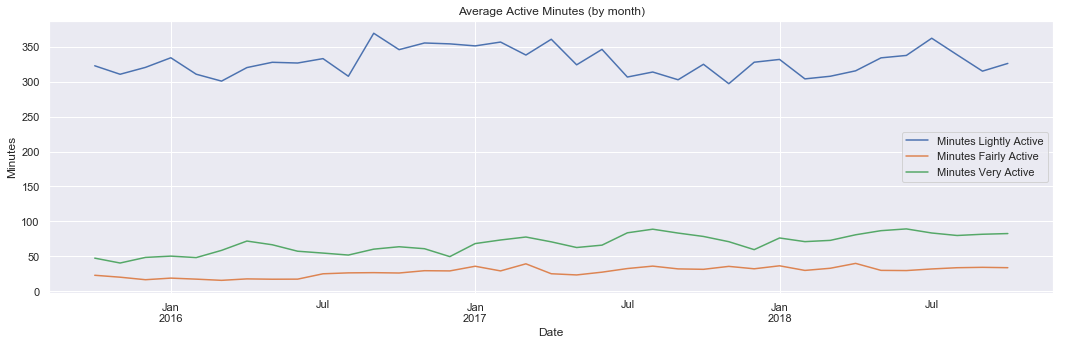

In [18]:
ACTIVITY_LEVELS = ['Minutes Lightly Active', 'Minutes Fairly Active', 'Minutes Very Active']

activities.resample('M').mean().plot(y=ACTIVITY_LEVELS, figsize=(18,5))
plt.ylabel('Minutes')
plt.title('Average Active Minutes (by month)')
plt.show()

Fitbit's activity levels are determined by an individual's MET (metabolic equivalent) score, a score used to measure energy expenditure from physical activity. MET score of some physical activities are as follows:

| PHYSICAL ACTIVITY | MET |
| --- | --- |
| **Sedentary** | **< 1** |
| Sleeping | 0.9 |
| **Light intensity activities** | **1 < 3** |
| Watching TV | 1 |
| Desk work (e.g., writing, typing) | 1.5 |
| Strolling | 2.3 |
| Walking (2.5 mph) | 2.9 |
| **Moderate intensity activities** | **3-6** |
| Yoga | 3.2 |
| Walking (3 mph) | 3.3 |
| Bicycling (<10 mph) | 4 |
| Walking upstairs | 4.7 |
| **High intensity activities** | **6 <** |
| Jogging | 7 |
| Jump rope | 10 |
| Weight training | 10.9 |
| Basketball | 11.1 |

#### Light intensity (blue)
- **Average:** 329
- **Standard deviation:** 70.59

Overall the "Minutes Lightly Active" line is very jagged and fluctuates with no obvious directional trend. This informs us that the amount of time Tracy spends on activities that require minimal or no physical exertion is very unpredictable (unless looking at the graph in segments).

#### Moderate intensity (orange)
- **Average:** 28.1
- **Standard deviation:** 15.48

The "Minutes Fairly Active" line is relatively stable throughout. Looking at the whole graph, there seems to be a slight increase in amount of time spent on activities of moderate intensity.

#### High intensity (green)
- **Average:** 68.39
- **Standard deviation:** 39.68

Tracy spends more than double the time doing vigorous activities than activities of moderate intensity. As seen on the graph, the line representing "Minutes Very Active" never meets the "Minutes Fairly Active" line. There also seems to be a slight increase in amount of time spent on high intensity activities over time.

#### Trends
From September 2016 to November 2017, there is an evident downward trend in "Minutes Lightly Active" while the opposite is observed for "Minutes Very Active". This points to high possibility that Tracy was involved in more vigorous activities during that timeframe.

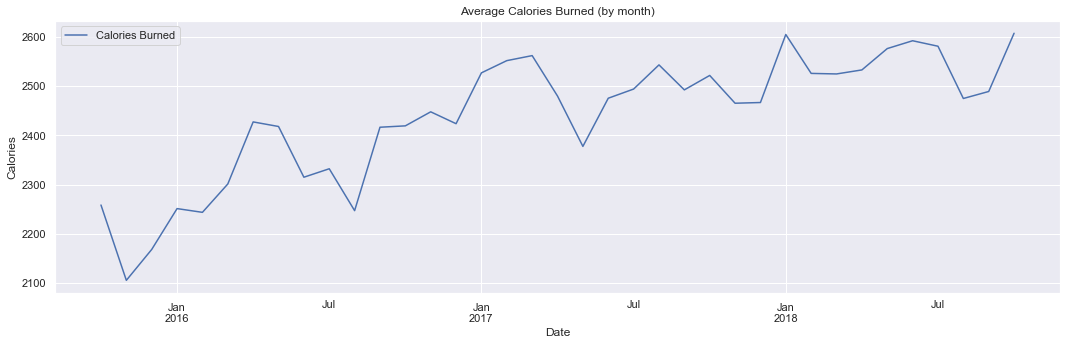

In [19]:
activities.resample('M').mean().plot(y='Calories Burned', figsize=(18,5))
plt.ylabel('Calories')
plt.title('Average Calories Burned (by month)')
plt.show()

Although not a smooth line, there is an obvious upward trend in amount of calories Tracy has burned. Earlier we have observed an apparent increase in her active minutes over time, which supports the observation just made.

Text(0.5,1,'Average Minutes Asleep')

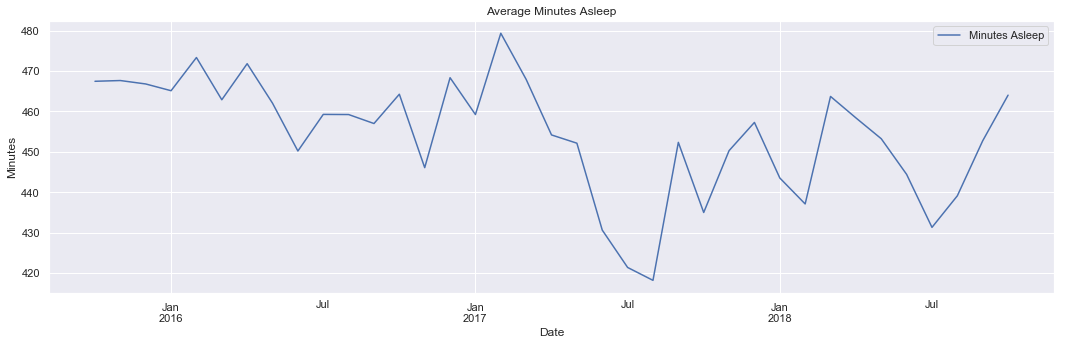

In [20]:
daily_sleep.resample('M').mean().plot(y='Minutes Asleep', figsize=(18,5))
plt.ylabel('Minutes')
plt.title('Average Minutes Asleep')

From February 2017 to July 2017, there is an evident downward trend, with the steepest negative slope from May 2017 to July 2017. This clearly informs us that Tracy has had less sleep during that time frame. From then till December 2017, we see a jagged, but upward trend, indicating a recovery of sleep time.

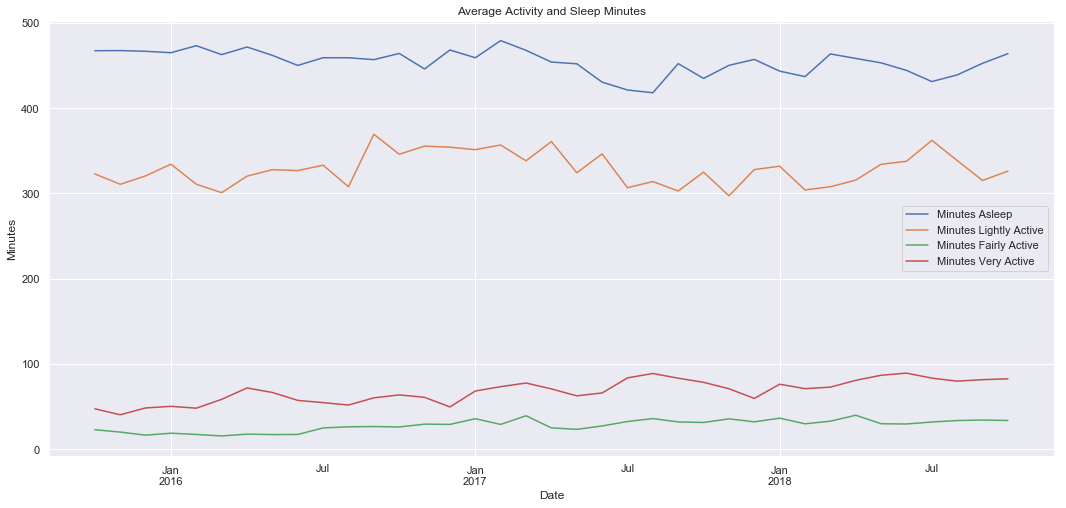

In [21]:
ax = daily_sleep.resample('M').mean().plot(y='Minutes Asleep', figsize=(18,5))
activities.resample('M').mean().plot(y=ACTIVITY_LEVELS, figsize=(18,8), ax=ax)
plt.ylabel('Minutes')
plt.title('Average Activity and Sleep Minutes')
plt.show()

Putting her activity and sleep data together, it seems that the line representing Tracy's sleep (blue) roughly follows the line representing the total duration she is lightly active (orange). It would be interesting to see if there is a correlation between the two.

Text(0.5,1,'Average Minutes Asleep vs Average Time in Bed')

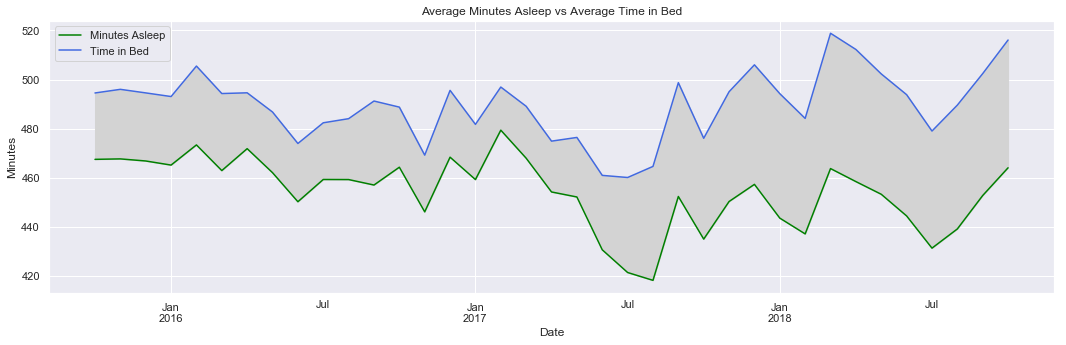

In [22]:
daily_sleep.resample('M').mean().plot(y=['Minutes Asleep', 'Time in Bed'], figsize=(18,5), \
                                      color=['green', 'royalblue'])

plt.fill_between(x = daily_sleep.resample('M').mean().index, y1 = daily_sleep.resample('M').mean()['Minutes Asleep'], \
                 y2 = daily_sleep.resample('M').mean()['Time in Bed'], color = 'lightgray')

plt.ylabel('Minutes')
plt.title('Average Minutes Asleep vs Average Time in Bed')

In [23]:
daily_sleep.resample('M').mean()#.index.shape

,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed
Date,,,,
2015-10-31,467.470155,19.200000,1.200000,494.517652
2015-11-30,467.655172,26.503436,2.275862,496.000000
2015-12-31,466.806452,27.322581,2.032258,494.548387
2016-01-31,465.134492,27.193548,2.354839,493.063254
2016-02-29,473.352891,23.172414,2.206897,505.482759
2016-03-31,462.893598,23.032258,2.322581,494.283366
2016-04-30,471.827586,22.068966,2.241379,494.586207
2016-05-31,462.039802,25.387097,2.193548,486.754586
2016-06-30,450.200000,23.400000,2.366667,473.933333


The space between the two lines represent the amount of time Tracy is awake during her sleep. Not only does it seem like Tracy has trouble staying asleep, but it seems to be getting worse.

### Can you make a bar plot or a histogram?

In [24]:
WEEK_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

activities_by_week = activities.groupby('Weekday').mean().reindex(WEEK_ORDER)
activities_by_week['Total Active Minutes'] = activities_by_week.iloc[:,6:8].sum(1)
activities_by_week

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Total Active Minutes
Weekday,,,,,,,,,,
Monday,2691.799835,19597.197420,7.861670,22.289973,452.833333,345.279247,32.340497,97.944359,1817.151859,130.284856
Tuesday,2541.158228,17618.044304,7.033481,20.594354,462.333333,380.724583,29.827113,67.259494,1694.573571,97.086607
Wednesday,2585.094135,19080.791527,7.612273,23.789873,465.242063,342.440632,31.716907,79.427059,1726.880463,111.143967
Thursday,2511.924051,16882.905063,6.734494,20.739923,519.500000,356.589374,30.751964,74.329114,1651.822785,105.081078
Friday,2280.078454,14510.057368,5.758990,19.885201,528.408730,344.020903,27.547431,42.126582,1383.902685,69.674013
Saturday,2406.584645,16308.152996,6.674723,22.616783,454.833333,275.612958,26.594136,78.640184,1499.791905,105.234320
Sunday,2076.241621,12368.982636,4.973717,18.581695,594.500000,258.209427,17.897133,38.895664,1127.552971,56.792797


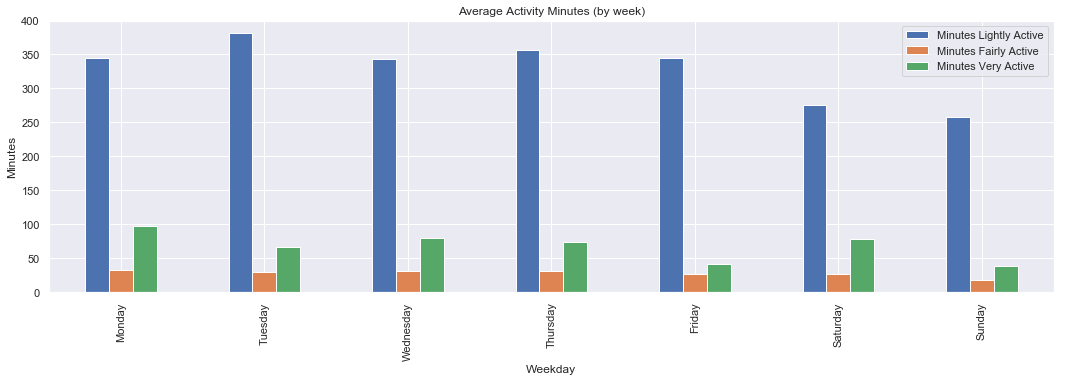

In [25]:
activities_by_week.plot(kind='bar', y=ACTIVITY_LEVELS, figsize=(18,5))
plt.ylabel('Minutes')
plt.title('Average Activity Minutes (by week)')
plt.show()

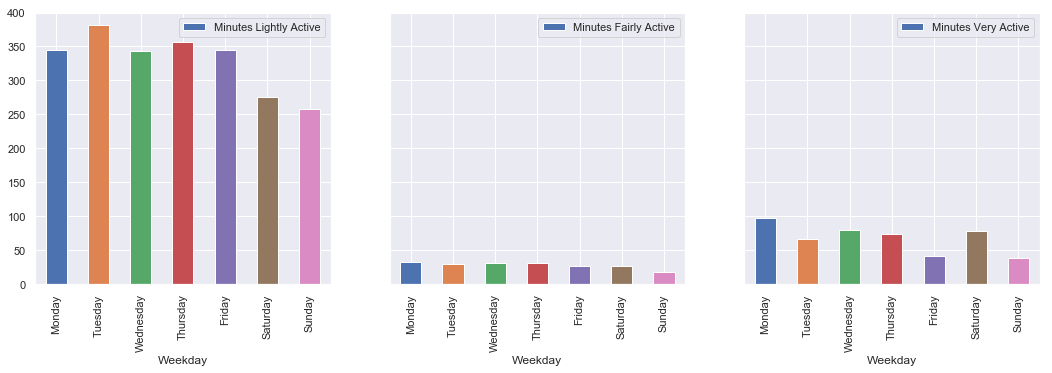

In [26]:
fig, activity_ax = plt.subplots(1, 3, sharey=True, figsize=(18,5))

for i, level in enumerate(ACTIVITY_LEVELS):
    activities_by_week.plot(kind='bar', y=level, ax=activity_ax[i])
plt.show()

For the most part, Tracy is more active during the week with the exception of Saturday. According to the statistics table, Saturday is actually one of her more active days ("Total Active Minutes" determined by summing the averages of "Minutes Fairly Active" and "Minutes Very Active").

---

Text(0.5,1,'Average Minutes Asleep (by week)')

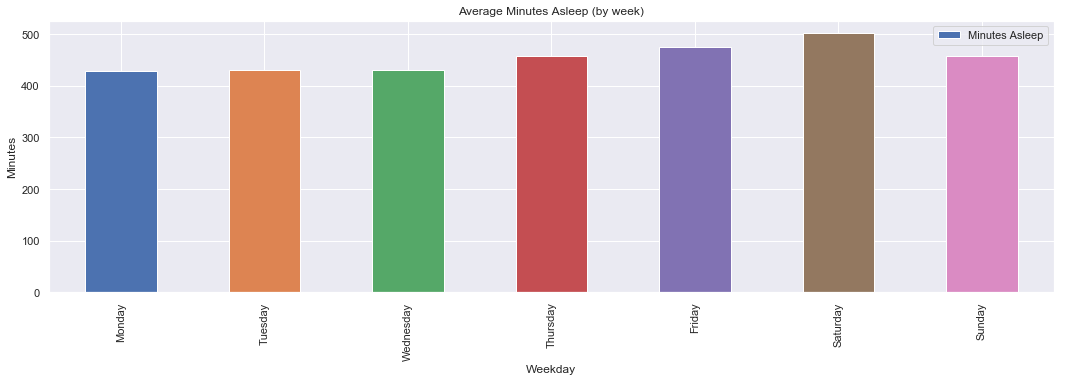

In [27]:
daily_sleep.groupby('Weekday').mean().reindex(WEEK_ORDER).plot(kind='bar', y='Minutes Asleep', figsize=(18,5))
plt.ylabel('Minutes')
plt.title('Average Minutes Asleep (by week)')

Tracy gets more sleep as the week comes to an end. She gets the most sleep on Saturdays, and the least from Monday to Wednesday.

### Can you compare two related quantities? Can you make a scatterplot?

Text(0.5,1,'Correlation between average minutes asleep and minutes lightly active')

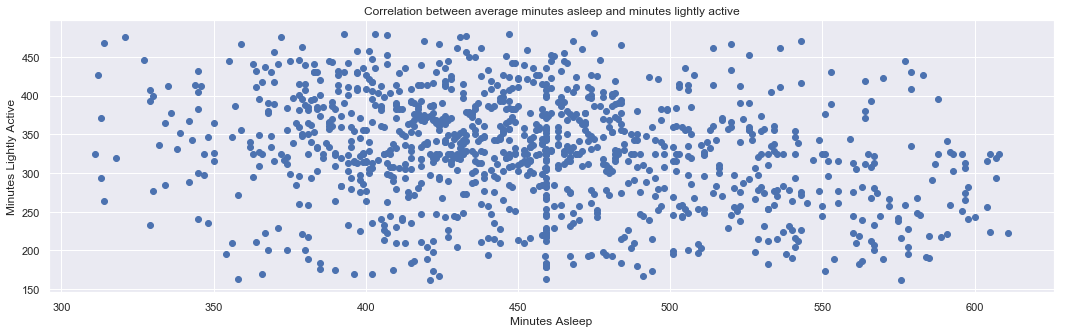

In [28]:
df = activities.merge(daily_sleep, on='Date')
plt.figure(figsize=(18,5))
plt.scatter(x=df['Minutes Asleep'], y=df['Minutes Lightly Active'])
plt.xlabel('Minutes Asleep')
plt.ylabel('Minutes Lightly Active')
plt.title('Correlation between average minutes asleep and minutes lightly active')

There doesn't seem to be a correlation between how much sleep Tracy gets and how active she is.

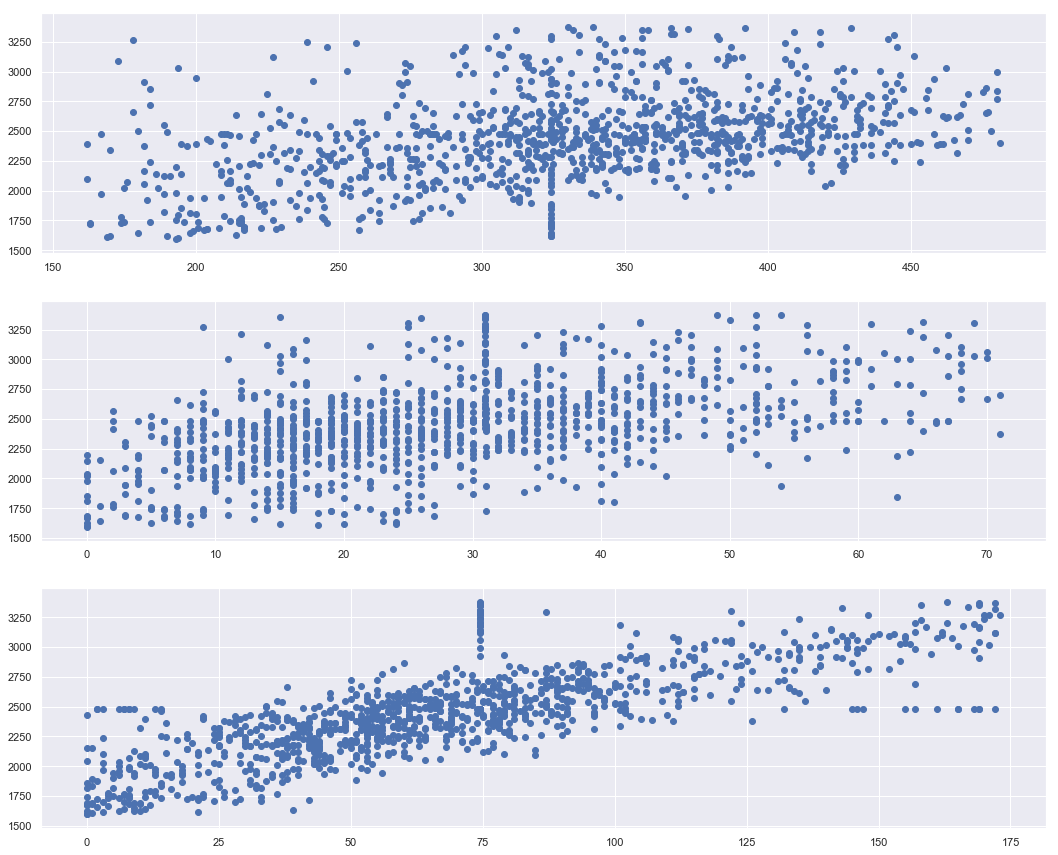

In [29]:
fig, ax = plt.subplots(3, 1, sharey=True, figsize=(18,15))

for i, level in enumerate(ACTIVITY_LEVELS):
    ax[i].scatter(x=activities[level], y=activities['Calories Burned'])

Without a doubt, there is a pretty clear positive correlation between the duration of her activeness (regardless of intensity) and how many calories she burns.

---

The idea behind fitness varies from individual to individual. Some get involved in fitness to chase after aesthetic goals, while some do it out of pure passion. There are also those who are engaged in living a healthy lifestyle to improve quality of life. Tracy, an Insanity instructor and home health aide, utilizes her Fitbit to primarily keep track of her activities and sleep, as well as food intake.

On average, Tracy burns 2,441.97 calories per day, 1,557.54 of which are calories burnt via activities of varying intensity levels. She shows evidence of high calorie expenditure due to her high activity levels. Although Sunday's are her most laid back days, she still engages in some form of high intensity activity every day. On average, Tracy gets 7 hours of sleep per day, but the quantity of her sleep has no affect on her performance at the gym. This is reasonable though due to the physical demands as and schedule commitment of a group exercise instructor.

We can see that some time towards the end of 2016 until mid 2017, there is a drop in amount of sleep and amount of time lightly active. Also, starting from mid 2017, her nights are becoming more and more restless. These findings are somewhat shocking and unexpected when considering she does get an average of 7 hours of sleep per day. Unfortunately, the data collected only allows us to do no more other than to make this discovery.

One correlation that was tested is the amount of calories she burns and her very active minutes, which obviously is confirmed to be a positive correlation. One relationship that would be interesting to test is the amount of carbs she consumes and the duration of her intensive workouts. Carbs are known to be a great source of fuel for the body, but some may abstain from carbs due to fad diets (e.g., keto diet). It would be intriguing to discover what kind of correlation can be detected between Tracy's carb intake and engagement in rigorous activities.

---

## Inferential Statistics

**Significance level** (for all tests): 0.05

---

### Minutes Very Active vs Calories Burned

**Null hypothesis:** There is no correlation between the amount of calories burned and duration of high intensity workouts.

**Alternative hypothesis:** There is a correlation between amount of calories burned and duration of high intensity workouts.

Text(0,0.5,'Calories Burned')

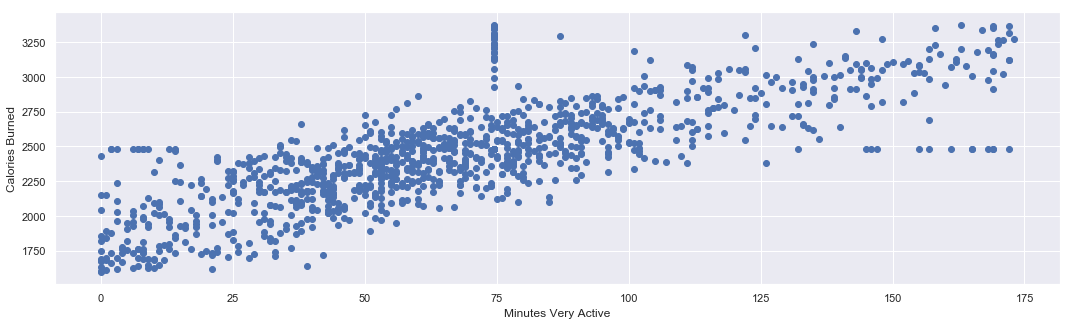

In [30]:
plt.figure(figsize=(18, 5))
plt.scatter('Minutes Very Active', 'Calories Burned', data=activities)

plt.xlabel('Minutes Very Active')
plt.ylabel('Calories Burned')

In [31]:
scipy_r, scipy_p = stats.pearsonr(activities['Minutes Very Active'], \
                                  activities['Calories Burned'])

print("Scipy's correlation coefficient:", scipy_r)
print("Scipy's p-value:", scipy_p)

Scipy's correlation coefficient: 0.7858467996449217
Scipy's p-value: 7.142083581912041e-233


The p-value is extremely small, so the null hypothesis is rejected. In fact, the correlation of 0.79 informs us her very active minutes has a huge impact on the amount of calories Tracy burns.

### Activity Calories vs Carb Intake

**Null hypothesis:** There is no correlation between activity calories and carb intake.

**Alternative hypothesis:** There is a correlation between activity calories and carb intake.

Text(0,0.5,'Activity Calories')

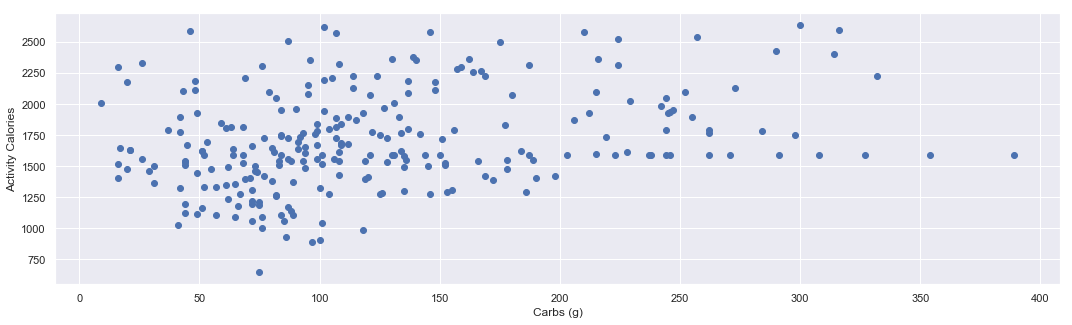

In [32]:
macros.index = pd.to_datetime(macros.index)

df1 = activities.merge(macros.iloc[:, 0:6], left_index=True, right_index=True)
plt.figure(figsize=(18, 5))
plt.scatter('Carbs (g)', 'Activity Calories', data=df1)

plt.xlabel('Carbs (g)')
plt.ylabel('Activity Calories')

In [33]:
scipy_r, scipy_p = stats.pearsonr(df1['Activity Calories'], df1['Carbs (g)'])

print("Scipy's correlation coefficient:", scipy_r)
print("Scipy's p-value:", scipy_p)

Scipy's correlation coefficient: 0.301696397595359
Scipy's p-value: 9.62446731823555e-07


The correlation of 0.3 informs us there is indeed a correlation between the amount of calories Tracy burns through activity and the amount of carbs she consumes. To further support the claim, the p-value is smaller than the significance level, therefore we reject the null hypothesis.

### Number of Awakenings vs Minutes Asleep

**Null hypothesis:** There is no correlation between number of awakenings and minutes asleep.

**Alternative hypothesis:** There is a correlation between number of awakenings and minutes asleep.

Text(0,0.5,'Minutes Asleep')

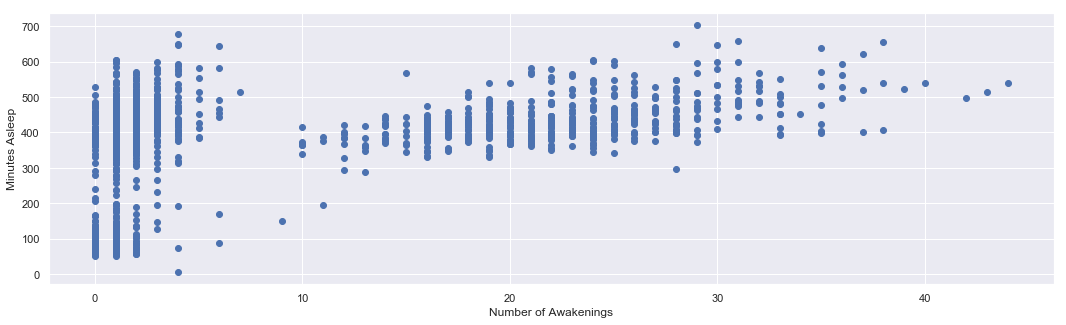

In [34]:
plt.figure(figsize=(18, 5))
plt.scatter('Number of Awakenings', 'Minutes Asleep', data=sleep)

plt.xlabel('Number of Awakenings')
plt.ylabel('Minutes Asleep')

In [35]:
scipy_r, scipy_p = stats.spearmanr(sleep['Number of Awakenings'], sleep['Minutes Asleep'])

print("Scipy's correlation coefficient:", scipy_r)
print("Scipy's p-value:", scipy_p)

Scipy's correlation coefficient: 0.38107089058809945
Scipy's p-value: 1.0564244602304605e-46


There is some positive correlation between number of awakenings and total amount of sleep Tracy gets. The p-value is extremely small so we reject the null hypothesis.

What's quite alarming is how much of a light sleeper Fitbit suggests Tracy to be. Although the correlation suggests she sleeps more as the amount of awakening increases, it may be of interest (for Tracy) to find a solution to help her get better, uninterrupted sleep.

---

## Machine Learning

In [36]:
# -- CREATING HEART RATE DATAFRAME --
hr_files = glob.glob('FitbitHR/*.csv')
list_of_heartrate_df = [pd.read_csv(file) for file in hr_files]

# -- GET DATA FROM FILE NAME --
list_of_dates = [re.search('FitbitHR/(\d{4}-\d{2}-\d{2}).csv', file).group(1) for file in hr_files]

# -- CREATE 'Date' COLUMN WITH list_of_dates --
for i, df in enumerate(list_of_heartrate_df):
    df['Date'] = list_of_dates[i]

heartrate_df = pd.concat(list_of_heartrate_df)
heartrate_df.Time = pd.to_datetime(heartrate_df['Time']).dt.time

In [37]:
max_hr = 220 - 46
# moderate intensity = 50-70% of max HR
# vigorous intensity = 70-85% of max HR

#len(sample[(sample['Heart Rate'] > max_hr * .5) & (sample['Heart Rate'] < max_hr * .65)])
#len(sample[(sample['Heart Rate'] > max_hr * .65)])
start = sleep.iloc[-27]['Start Time'].time()
end = sleep.iloc[-27]['End Time'].time()
#sample[sample['Time'] > start]

In [38]:
#sleep.iloc[-27]#['Start Time'].time()

### Supervised Learning -- Predicting Calories Burned with Sum of Heart Rates per Day

In [39]:
# -- CHANGING DATE TYPE OF COLUMNS --
to_date(heartrate_df, ['Date'])
heartrate_df['Date'] = heartrate_df['Date'].dt.date

activities.index = activities.index.date
daily_sleep.index = daily_sleep.index.date


# -- GROUP HEART RATE DATA BY DAY --
hr_daily_avg = heartrate_df.groupby('Date').sum()#.to_frame().reset_index()

for i in range(len(hr_daily_avg)):
    index_value = hr_daily_avg.index[i]
    hr_daily_avg.loc[index_value, 'Calories Burned'] = int(activities.loc[index_value]['Calories Burned'])
    
hr_daily_avg.head()

,Heart Rate,Calories Burned
Date,,
2017-07-28,94250,2463.0
2017-07-29,97507,3122.0
2017-07-30,88024,1894.0
2017-07-31,107820,2894.0
2017-08-01,104097,2596.0


In [40]:
from sklearn import linear_model, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

# -- SPLIT TO TEST AND TRAINING SET --
X_train, X_test, y_train, y_test = train_test_split(hr_daily_avg['Heart Rate'].values.reshape(-1,1), hr_daily_avg['Calories Burned'].values.reshape(-1,1), test_size = 0.3, random_state = 42)

# -- LINEAR REGRESSION --
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('LINEAR REGRESSION')
print('-----------------')
print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)), '\n')

# -- CROSS VALIDATION --
cv_results = cross_val_score(reg, hr_daily_avg['Heart Rate'].values.reshape(-1,1), hr_daily_avg['Calories Burned'].values.reshape(-1,1), cv = 5)
print('Cross validation results:', cv_results, '\n\n')


# -- RANDOM FOREST REGRESSOR --
forest = RandomForestRegressor(100)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

print('RANDOM FOREST REGRESSOR')
print('-----------------------')
print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)), '\n')

# -- CROSS VALIDATION --
cv_results = cross_val_score(forest, hr_daily_avg['Heart Rate'].values.reshape(-1,1), hr_daily_avg['Calories Burned'].values.reshape(-1,1), cv = 5)
print('Cross validation results:', cv_results)

LINEAR REGRESSION
-----------------
Mean absolute error: 254.0439952186634
Mean error: 318.9759096861196 

Cross validation results: [4.30442215e-01 5.13484679e-01 6.18710762e-01 3.74846329e-01
 6.04609026e-04] 


RANDOM FOREST REGRESSOR
-----------------------
Mean absolute error: 237.86294964028775
Mean error: 318.1571875440994 

Cross validation results: [0.31434301 0.39337123 0.53898889 0.27872813 0.14352872]


Looking at both mean absolute error and mean error, Random Forest Regressor is the better model. However, both models, on average, will make an average error of 200+ calories. Both models underfit the training data. What can be done is to add more features or use more powerful models. However, it is important to once again note that Tracy is in fact a group exercise instructor who has a busy teaching schedule to follow. There certain times of certain days where she will be working out, and all other activity data are dependent on how active minutes. This creates limitations in building strong models. 

### Heart rate data by times of day (morning, afternoon, evening)

In [41]:
# -- ONE MINUTE UNTIL THE END OF EACH TIME OF DAY --
MORNING = dt.time(11, 59)
AFTERNOON = dt.time(17, 59)
EVENING = dt.time(23, 59)

# -- CREATING 'Time_of_Day' COLUMN --
heartrate_df.loc[heartrate_df.Time <= MORNING, 'Time_of_Day'] = 'Morning'
heartrate_df.loc[(heartrate_df.Time > MORNING) & (heartrate_df.Time <= AFTERNOON), 'Time_of_Day'] = 'Afternoon'
heartrate_df.loc[(heartrate_df.Time > AFTERNOON) & (heartrate_df.Time <= EVENING), 'Time_of_Day'] = 'Evening'

# -- CREATING NEW DATAFRAME TO WORK WITH --
tod = heartrate_df.groupby(['Date', 'Time_of_Day'], sort=False).mean()
df2 = pd.merge(tod, activities[['Calories Burned']], left_on = 'Date', right_index = True)
df2 = df2.rename_axis(['Date', 'Time of Day']).reset_index()
df2.head()

,Date,Time of Day,Heart Rate,Calories Burned
0,2017-07-28,Morning,73.761024,2463.0
1,2017-07-28,Afternoon,65.136872,2463.0
2,2017-07-28,Evening,53.139276,2463.0
3,2017-07-29,Morning,80.937951,3122.0
4,2017-07-29,Afternoon,64.338889,3122.0


In [42]:
# -- SPLIT INTO THREE DIFFERENT DATAFRAMES, BY TIME OF DAY --
morning, afternoon, evening = df2.groupby('Time of Day')

morning = morning[1]
afternoon = afternoon[1]
evening = evening[1]

# -- CREATING THE TRAIN AND TEST SETS --
X_train1, X_test1, y_train1, y_test1 = train_test_split(morning.drop(['Date', 'Time of Day', 'Calories Burned'], \
                                                        axis = 1).values, morning['Calories Burned']\
                                                        .values.reshape(-1,1), test_size = 0.3, random_state = 42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(afternoon.drop(['Date', 'Time of Day', 'Calories Burned'], \
                                                        axis = 1).values, morning['Calories Burned']\
                                                        .values.reshape(-1,1), test_size = 0.3, random_state = 42)
X_train3, X_test3, y_train3, y_test3 = train_test_split(evening.drop(['Date', 'Time of Day', 'Calories Burned'], \
                                                        axis = 1).values, morning['Calories Burned']\
                                                        .values.reshape(-1,1), test_size = 0.3, random_state = 42)

# -- FITTING AND PREDICTING RANDOM FOREST REGRESSOR MODELS --
forest1 = RandomForestRegressor()
forest2 = RandomForestRegressor()
forest3 = RandomForestRegressor()

forest1.fit(X_train1, y_train1)
forest2.fit(X_train2, y_train2)
forest3.fit(X_train3, y_train3)

y_pred1 = forest1.predict(X_test1)
y_pred2 = forest2.predict(X_test2)
y_pred3 = forest3.predict(X_test3)

print('MORNING')
print('-------')
print('Mean absolute error:', metrics.mean_absolute_error(y_test1, y_pred1))
print('Mean error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred1)), '\n')

print('AFTERNOON')
print('---------')
print('Mean absolute error:', metrics.mean_absolute_error(y_test2, y_pred2))
print('Mean error:', np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)), '\n')

print('EVENING')
print('-------')
print('Mean absolute error:', metrics.mean_absolute_error(y_test3, y_pred3))
print('Mean error:', np.sqrt(metrics.mean_squared_error(y_test3, y_pred3)))

MORNING
-------
Mean absolute error: 347.56205913318126
Mean error: 425.7747713078065 

AFTERNOON
---------
Mean absolute error: 402.50188161665795
Mean error: 507.0742748323397 

EVENING
-------
Mean absolute error: 245.0679729387222
Mean error: 311.2575055180102


Using the average heart rate by time of day to estimate calories burned, we get the above results for each model. Regardless of time of day, neither of the three average heart rates seem to be good predictors for the amount of calories burned for the day. The smallest prediction error of the three models is off by at least 230 calories, which is quite substantial--it would take 15-20 minutes of jump roping to burn off about 200 calories. This suggests all models are underfitting. More features might be necessary to improve the models.

In [43]:
# -- CREATING ANOTHER DATAFRAME WITH AVERAGE HEART RATE BY DAY AS FEATURES --
df3 = pd.pivot_table(tod, index='Date', columns=['Time_of_Day']).merge(activities[['Calories Burned']], \
                                                                       left_on = 'Date', right_index = True)
df3.head()

,"(Heart Rate, Afternoon)","(Heart Rate, Evening)","(Heart Rate, Morning)",Calories Burned
Date,,,,
2017-07-28,65.136872,53.139276,73.761024,2463.0
2017-07-29,64.338889,51.422535,80.937951,3122.0
2017-07-30,63.529248,59.608333,62.333333,1894.0
2017-07-31,74.052778,78.130556,74.801128,2894.0
2017-08-01,74.291066,59.798319,80.466102,2596.0


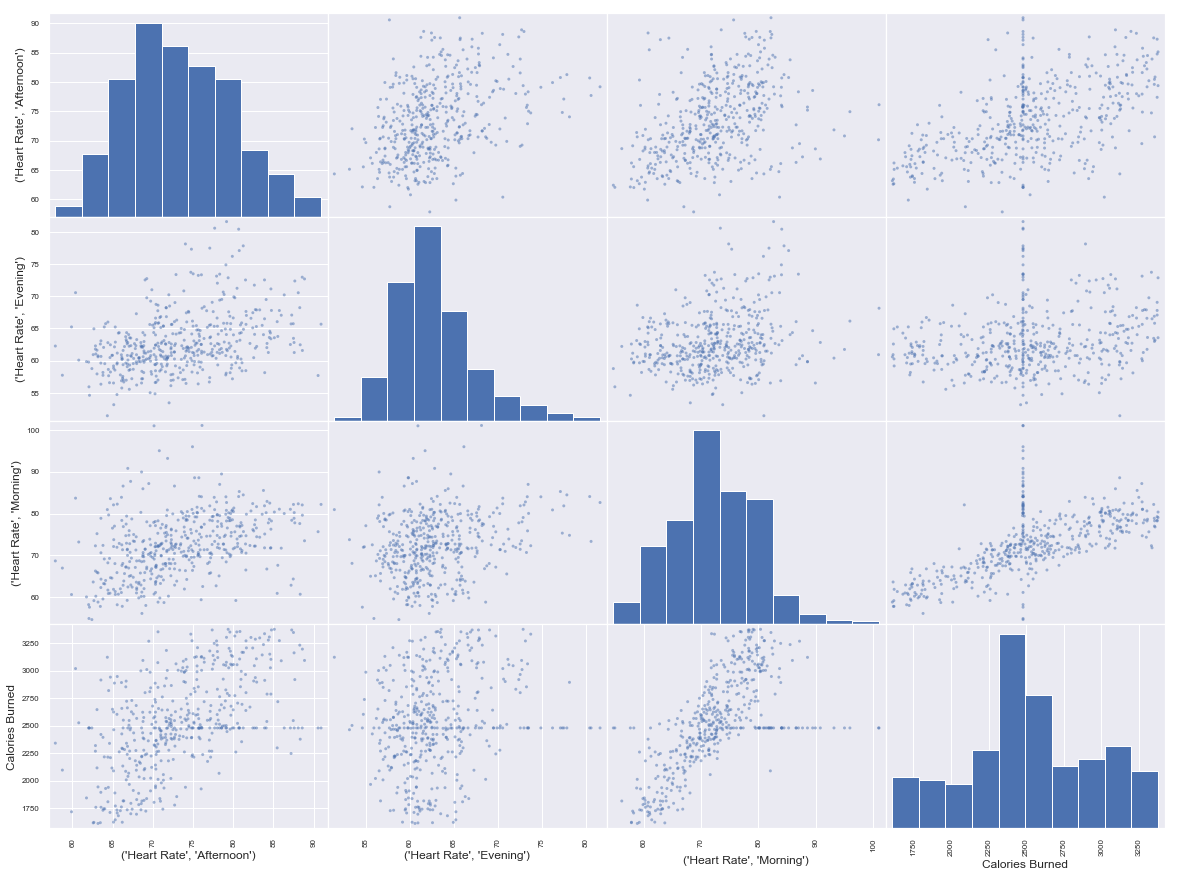

In [44]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(df3, figsize=(20,15))
plt.show()

In [45]:
corr_matrix = df3.corr()
corr_matrix['Calories Burned'].sort_values(ascending=False)

Calories Burned            1.000000
(Heart Rate, Morning)      0.670534
(Heart Rate, Afternoon)    0.551445
(Heart Rate, Evening)      0.208197
Name: Calories Burned, dtype: float64

Based on the correlation and scatter matrices above, there are no two features that have a strong correlation with each other. The feature most correlated with 'Calories Burned' is 'Heart Rate, Morning'.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df3.drop('Calories Burned', axis = 1).values, \
                                                    df3['Calories Burned'].values.reshape(-1,1), \
                                                    test_size = 0.3, random_state = 42)

model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

cross_val_score(model, df3.drop('Calories Burned', axis=1), df3['Calories Burned'].values.reshape(-1,1), cv=5)

Mean absolute error: 176.13822308007252
Mean error: 231.07079241503956


array([0.47658132, 0.74204889, 0.8132803 , 0.55916131, 0.37963921])

Restructuring the dataframe and have average heart rate by time of day as features creates a better model. The mean absolute error is now under 200 calories.

### Unsupervised Learning

Text(0,0.5,'Inertias')

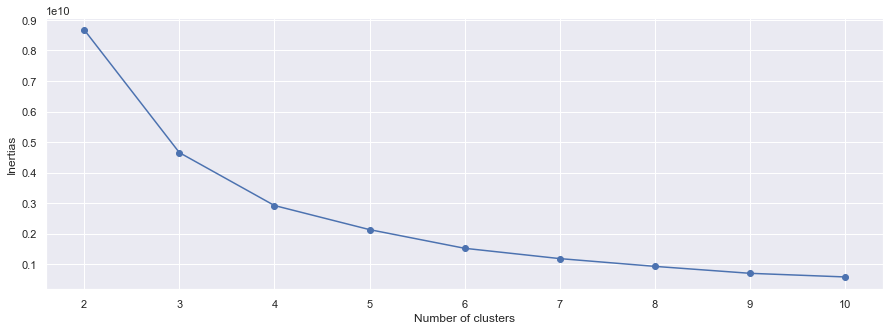

In [47]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

x_cols = np.array(hr_daily_avg.reset_index(drop=True))

# -- CHOOSING K --
ks = np.arange(2,11)
inertias = []
for k in ks:
    model = KMeans(n_clusters = k, random_state = 42)
    model.fit(x_cols)
    inertias.append(model.inertia_)

plt.figure(figsize=(15,5))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertias')

Text(0.5,1,'Plot for K = 3')

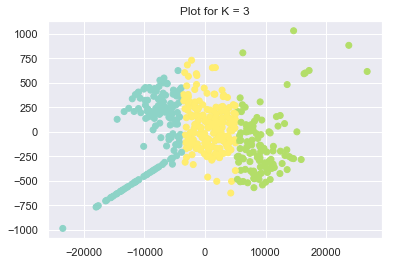

In [48]:
k = KMeans(n_clusters = 3, random_state = 42)
hr_daily_avg['cluster'] = k.fit(x_cols).labels_

model = PCA(n_components = 2)
transformed = model.fit_transform(x_cols)
hr_daily_avg['x'] = transformed[:,0]
hr_daily_avg['y'] = transformed[:,1]

plt.scatter('x', 'y', c = 'cluster', cmap='Set3', data = hr_daily_avg)
plt.title('Plot for K = 3')

In [49]:
# -- AVOID MERGING DUPLICATE COLUMNS --
cols_to_use = activities.columns.difference(hr_daily_avg.columns)

# -- MERGING hr_daily_avg, activities, and sleep_night DATAFRAMES --
df = pd.merge(hr_daily_avg, activities[cols_to_use], left_index=True, right_index=True).drop(['x', 'y'], axis = 1)
df = pd.merge(df, sleep_night, left_index=True, right_index=True)

df['is 0'] = df['cluster'] == 0
df['is 1'] = df['cluster'] == 1
df['is 2'] = df['cluster'] == 2

df.head()

,Heart Rate,Calories Burned,cluster,Activity Calories,Distance,Floors,Minutes Fairly Active,Minutes Lightly Active,Minutes Sedentary,Minutes Very Active,Steps,Weekday,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,is 0,is 1,is 2
2017-07-28,94250,2463.0,2,1624.0,5.900000,21.0,66.0,336.0,NaN,67.0,15000.000000,Friday,428,56,24,484,False,False,True
2017-07-29,97507,3122.0,2,2267.0,7.033451,43.0,40.0,227.0,NaN,172.0,17156.532069,Saturday,486,112,19,598,False,False,True
2017-07-30,88024,1894.0,1,929.0,3.370000,21.0,10.0,317.0,NaN,1.0,8462.000000,Sunday,373,26,16,399,False,True,False
2017-07-31,107820,2894.0,0,2068.0,7.980000,21.0,58.0,345.0,NaN,115.0,20227.000000,Monday,398,38,25,436,True,False,False
2017-08-01,104097,2596.0,0,1713.0,7.650000,16.0,35.0,299.0,NaN,97.0,18712.000000,Tuesday,375,73,27,448,True,False,False


In [50]:
print('CLUSTER 0:')
print(df[df['is 0']].Weekday.value_counts(), '\n')
print('CLUSTER 1:')
print(df[df['is 1']].Weekday.value_counts(), '\n')
print('CLUSTER 2:')
print(df[df['is 2']].Weekday.value_counts())

CLUSTER 0:
Monday       51
Wednesday    45
Saturday     22
Tuesday      12
Friday        7
Thursday      5
Sunday        2
Name: Weekday, dtype: int64 

CLUSTER 1:
Sunday      52
Friday      21
Saturday    18
Thursday    10
Tuesday      7
Monday       2
Name: Weekday, dtype: int64 

CLUSTER 2:
Tuesday      47
Thursday     46
Friday       28
Saturday     25
Wednesday    20
Monday       12
Sunday       11
Name: Weekday, dtype: int64


Based on KMeans, it was determined that 3 clusters yields optimal results. By examining each of the three clusters, it seems that day of week is deterministic of how the clusterings are formed. **Cluster 0** contains mostly Monday's and Wednesday's, **Cluster 1** contains Thursday's and Tuesday's, and **Cluster 2** contains Sunday's and Friday's. Saturday's are somewhat evenly spread across the clusters.

In [51]:
print('\nMINUTES SEDENTARY')
print('-----------------')
print('Cluster 0:', df[df['is 0']]['Minutes Sedentary'].mean())
print('Cluster 1:', df[df['is 1']]['Minutes Sedentary'].mean())
print('Cluster 2:', df[df['is 2']]['Minutes Sedentary'].mean())

print('\nMINUTES LIGHTLY ACTIVE')
print('----------------------')
print('Cluster 0:', df[df['is 0']]['Minutes Lightly Active'].mean())
print('Cluster 1:', df[df['is 1']]['Minutes Lightly Active'].mean())
print('Cluster 2:', df[df['is 2']]['Minutes Lightly Active'].mean())

print('\nMINUTES FAIRLY ACTIVE')
print('---------------------')
print('Cluster 0:', df[df['is 0']]['Minutes Fairly Active'].mean())
print('Cluster 1:', df[df['is 1']]['Minutes Fairly Active'].mean())
print('Cluster 2:', df[df['is 2']]['Minutes Fairly Active'].mean())

print('\nMINUTES VERY ACTIVE')
print('-------------------')
print('Cluster 0:', df[df['is 0']]['Minutes Very Active'].mean())
print('Cluster 1:', df[df['is 1']]['Minutes Very Active'].mean())
print('Cluster 2:', df[df['is 2']]['Minutes Very Active'].mean())


MINUTES SEDENTARY
-----------------
Cluster 0: 355.45454545454544
Cluster 1: 536.8065476190476
Cluster 2: 454.8181818181818

MINUTES LIGHTLY ACTIVE
----------------------
Cluster 0: 337.64793485897826
Cluster 1: 280.41899482631186
Cluster 2: 336.9331383260922

MINUTES FAIRLY ACTIVE
---------------------
Cluster 0: 40.01759635651912
Cluster 1: 21.936363636363637
Cluster 2: 34.25624811803674

MINUTES VERY ACTIVE
-------------------
Cluster 0: 114.01211984342065
Cluster 1: 30.5
Cluster 2: 81.5000788632225


Further investigation is done by looking into her active/sedentary minutes. Within the sedentary, cluster 2 has the highest mean. This possibly indicates cluster 2 contains data points that reflect Tracy's rest days. From the analysis above, cluster 2 contains mostly Sunday's and Friday's. Looking at the visualizations of Tracy's data, it is indeed true that Sunday's and Friday's are Tracy's less active days.

Looking at 'Minutes Very Active' for all clusters, cluster 0 has the highest mean value, at 86.51 minutes--more than 2 hours! Data points with labels 'Monday' and 'Wednesday' are likely to be in cluster 0. Monday's and Wednesday's are two of Tracy's workout intensive days (further confirmed by Tracy, who has taught 2-3 classes both days for an extended period of time). At this point, it is clear that data points in cluster 0 represent days of increased activity.

Nothing striking is noticed for data points in cluster 1. Data points in this cluster never has the highest or lowest average. Data points in cluster 1 could be representative of days where Tracy teaches a little less and spends more time at her home health aide job.